In [14]:
#Modules to make the code run

from shapely.geometry import Point, Polygon
from multiprocessing import  Pool
import pandas as pd
import numpy as np
import os
import geopandas as gpd

import folium
from folium.plugins import HeatMap
import shapely.wkt

import matplotlib.pyplot as plt
from geopandas import GeoDataFrame, GeoSeries
import datetime
import branca

from keplergl import KeplerGl


## DATA WRANGLING

### Uber Datasets (CREATE ONE DATASET)

We explore the uber datasets provided in 2014 and 2015, they do not share the same structure. The 2014 dataset has information about coordinates, meanwhile the 2015 dataset provide the pickup_id location. Based on this fact and using the 'zones.csv' dataset we decided to group both datasets using the 'NTA CODE', and preserved the pick_up date which both files share:

- In order to make this conversion we also explore the geographic.csv, which contains the borders of New York's NTA (Neighborhood Tabulation Areas), this dataset is incomplete. We replace it with 'nynta.csv', a dataset from NYC Open Data that contains the full information needed. 
- Defining a function to apply the geographic info to uber 2014 dataset, parallizing it we create a new uber 2014 dataset containing the nta code.
- After creating the new dataset we take the common columns between 2014 and 2015 to create 1 big dataset.


In [ ]:
#Reading geographic info, init the coordinate reference system and reading the zones dataset, which join the pickup location id with NTA.
nyc_zones = pd.read_csv('data/nynta.csv').set_index('NTACode')
nyc_zones['the_geom'] = nyc_zones['the_geom'].apply(lambda x: shapely.wkt.loads(x))
gps = gpd.GeoDataFrame(nyc_zones, geometry=nyc_zones['the_geom'])
gps.crs = {'init': 'epsg:4326'}
zones = pd.read_csv('data/zones.csv')

In [ ]:
#Create a function to return zones using the geographic 
def getZone(longitude, latitude, zones=gps['the_geom'].to_dict()):
    for zone in zones:
        if Point(longitude,latitude).within(zones[zone]):
            return zone

In [ ]:
#Parallizing the function to let python use multiple cores for fast proccessing.
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def apply_zone(df):
    return df.apply(lambda row: getZone(row['pickup_longitude'], row['pickup_latitude']), axis = 1)

In [ ]:
#This code will use a lot of RAM, use only if you want to redo the 2014 dataset
uber_trips_2014 = pd.read_csv('data/uber_trips_2014.csv') #Reading the 2014 uber dataset
uber_trips_2014 = uber_trips_2014[['pickup_datetime','pickup_latitude','pickup_longitude']]
uber_trips_2014['nta_code'] = parallelize_dataframe(uber_trips_2014, apply_zone)
#After run the snippet of code you can use pd.to_csv('data/uberTrips2014_zones.csv') to save the dataset as csv.

#### Mergin ALL Into 1 dataset

One last step to ensure data consistency with date format in both files. (This snippet take a lot of RAM, run only if you need to redo this file) 

In [ ]:
uber_trips_2014 = pd.read_csv('data/uberTrips2014_zones.csv')
uber_trips_2015 = pd.read_csv('data/uber_trips_2015.csv')
uber_trips_2015.drop(['dispatch_base','affiliate_base'], axis=1, inplace=True) # dropping base info we don't need. 
# finding the nta_code in 2015
uber_trips_2015 = uber_trips_2015.merge(zones, left_on = 'pickup_location_id', right_on = 'location_id')[['pickup_datetime', 'nta_code']]
# ensuring the datetime consistency.
uber_trips_2015['pickup_datetime'] = pd.to_datetime(uber_trips_2015['pickup_datetime'])
uber_trips_2014['pickup_datetime'] = pd.to_datetime(uber_trips_2014['pickup_datetime'])
# dropping the extra columns in 2014 dataset
uber_trips_2014 = uber_trips_2014[['pickup_datetime','nta_code']]
# creating one dataset
uber_unido = pd.concat([uber_trips_2014, uber_trips_2015])
uber_unido.to_csv('data/uber_14_15.csv', index=False)

In [ ]:
#Grouping by 30 minutes or dates and saving a summarized dataset
uber_unido['YYYY-MM-DD'] = uber_unido['pickup_datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
uber_unido['30 mins'] = uber_unido['pickup_datetime'].apply(lambda x: x.strftime('%Y-%m-%d')) + ' ' + uber_unido['pickup_datetime'].apply(lambda x: '{0}:{1}'.format(x.strftime('%H'), '30' if x.minute >= 30  else '00'))
uber_unido.to_csv('data/uber_14_15_m_d_30.csv')
uber_unido = pd.read_csv('data/uber_14_15_m_d_30.csv')
uber_unido.drop('Unnamed: 0', axis=1)
pd.DataFrame(uber_unido.groupby(['30 mins','nta_code', 'YYYY-MM','YYYY-MM-DD']).count()['pickup_datetime']).to_csv('data/grouped_uber.csv')

<font color = 'blue'>
    <h2> Loading DATASETS to start working (You can start here)</h2>
</font>

After creating the uber dataset we can start more advanced analysis.

In [12]:
data = pd.read_csv('data/grouped_uber.csv')
nyc_zones = pd.read_csv('data/nynta.csv').set_index('NTACode')

### Geographi Data

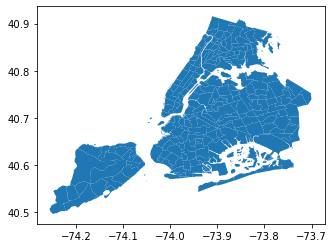

In [13]:
nyc_zones['the_geom'] = nyc_zones['the_geom'].apply(lambda x: shapely.wkt.loads(x))
gps = gpd.GeoDataFrame(nyc_zones, geometry=nyc_zones['the_geom'])
gps.crs = {'init': 'epsg:4326'}
gps.plot()

In [6]:
print(data.head())
print(data.tail())

           30 mins nta_code  YYYY-MM  YYYY-MM-DD  pickup_datetime
0  2014-04-0100:00     BK32  2014-04  2014-04-01                1
1  2014-04-0100:00     BK37  2014-04  2014-04-01                1
2  2014-04-0100:00     BK64  2014-04  2014-04-01                1
3  2014-04-0100:00     BK69  2014-04  2014-04-01                1
4  2014-04-0100:00     BK73  2014-04  2014-04-01                2
                 30 mins nta_code  YYYY-MM  YYYY-MM-DD  pickup_datetime
1456936  2015-06-3023:30     QN70  2015-06  2015-06-30               12
1456937  2015-06-3023:30     QN71  2015-06  2015-06-30                7
1456938  2015-06-3023:30     QN72  2015-06  2015-06-30               15
1456939  2015-06-3023:30     QN98  2015-06  2015-06-30              135
1456940  2015-06-3023:30     SI22  2015-06  2015-06-30                1


In [21]:
data_summary = data.groupby(['YYYY-MM-DD', 'nta_code'])['pickup_datetime'].sum().reset_index()
data_summary.set_index('nta_code')
data_summary = data_summary[data_summary['YYYY-MM-DD'] == '2015-01-01']
data_summary.set_index('nta_code', inplace=True)
colorscale = branca.colormap.linear.YlOrRd_09.scale(0, data_summary['pickup_datetime'].max())
colorscale

In [22]:
#creating data to plot in the map
gps1 = gps[['NTAName', 'geometry']].join(data_summary['pickup_datetime']).copy()
gps1.head()
data_summary.shape

(187, 2)

In [23]:
map_1 = KeplerGl(height=500)
map_1.add_data(data=gps1, name='NYC')
map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'NYC': {'index': ['BK43', 'BK75', 'BX40', 'BK88', 'BK96', 'QN52', 'QN53', 'BK44', 'QN48', 'BX44…

In [24]:
dir(map_1)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_notifiers',
 '_call_widget_constructed',
 '_comm_changed',
 '_compare',
 '_cross_validation_lock',
 '_default_keys',
 '_display_callbacks',
 '_dom_classes',
 '_gen_repr_from_keys',
 '_get_embed_state',
 '_handle_custom_msg',
 '_handle_displayed',
 '_handle_msg',
 '_holding_sync',
 '_ipython_display_',
 '_is_numpy',
 '_lock_property',
 '_log_default',
 '_model_id',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_msg_callbacks',
 '_notify_trait',
 '_property_lock',
 '_register_validator',
 '_remove_notifiers',
 '_repr_keys',
 '_send',
 '_should_send_property

## EDA